# KOH Posterior Analysis using Mici

This notebook looks at the different ways to implement an MCMC algorithm using Gaussian random-walk Metropolis proposal under the Mici framework.

The goal is to discover the best set-up and compare results against the MATLAB code previously implemented.

First, import the required packages and set up the KOH and Mici frameworks.

In [1]:
import matlabmodel2 as mm
from dataloader import DataLoader
from mappings import mapRto01, map01toR, mapRto0inf, map0inftoR, ell2rho, beta2ell
from jax import jit

import numpy as np
import mici

import matplotlib.pyplot as plt

import arviz

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [2]:
seed = 1234
n_chain = 1
n_dim = 7
n_warm_up_iter = 4000
n_main_iter = 10000
rng = np.random.default_rng(seed)

init_states = np.array([[
    map01toR(0.4257), 
    map0inftoR(beta2ell(51.5551)), #these are the beta values!!!
    map0inftoR(beta2ell(3.5455)), 
    map0inftoR(beta2ell(60)), 
    map0inftoR(0.25557), 
    map0inftoR(37.0552), 
    map0inftoR(10030.5142), 
    map0inftoR(79548.2126)
]])
num_params = init_states.shape[1]

tmax = 0.6
tmin = 0.2


##### KOH Model #####
# jitted_neg_log_posterior_density = jit(neg_log_dens)
dataloader = DataLoader()
data = dataloader.get_data() # loads normalised/standardised data
model = mm.MatlabModel(*data)
jitted_neg_log_posterior_density = jit(model.get_neg_log_dens_func())

##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=jitted_neg_log_posterior_density,
    grad_neg_log_dens=lambda q: q * 0,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

## Setup 1

Adapters:
- DualAveragingStepSizeAdapter(0.234)
- OnlineCovarianceMetricAdapter()

Results:
- Fails to achieve the target acceptance rate of 0.234, instead achieves around 0.2
- ESS bulk values are very similar for each variable.
- Parameter estimate for $\theta$ is very good. 
- 

In [3]:
##### Mici sampler and adapters #####
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=1)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.234),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, n_main_iter, init_states, adapters=adapters, n_process=n_chain
)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Sampling stage: Initial fast adaptive [00:00] > Slow adaptive (1/7) [00:00] > Slow adaptive (2/7) [00:00] > Slow adaptive (3/7) [00:00] > Slow adaptive (4/7) [00:01] > Slow adaptive (5/7) [00:02] > Slow adaptive (6/7) [00:05] > Slow adaptive (7/7) [00:14] > Final fast adaptive [00:00] > Main non-adaptive [00:43]

Chain 1/1: 100%|██████████|10000/10000 [00:43<00:00, 227.58it/s, accept_stat=0.103]

# Analyse the Chains

In [4]:
arviz.summary(traces)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pos[0],-0.277,0.144,-0.588,-0.046,0.011,0.008,164.0,236.0,NaN
pos[1],-2.335,0.032,-2.406,-2.282,0.002,0.001,232.0,315.0,NaN
pos[2],-0.952,0.057,-1.043,-0.832,0.003,0.002,265.0,305.0,NaN
pos[3],-18.568,15.071,-50.064,-2.185,8.319,6.502,3.0,24.0,NaN
pos[4],-1.351,0.206,-1.761,-1.004,0.013,0.009,283.0,189.0,NaN
pos[5],3.517,0.272,2.972,4.016,0.013,0.009,417.0,559.0,NaN
pos[6],9.054,0.359,8.339,9.664,0.022,0.016,271.0,268.0,NaN
pos[7],11.265,0.118,11.067,11.500,0.007,0.005,282.0,274.0,NaN
hamiltonian,-785.863,2.732,-790.512,-780.724,0.125,0.088,487.0,887.0,NaN


In [5]:
for i in range(num_params):
    print(np.mean(traces['pos'][0][:, i]), '±', np.std(traces['pos'][0][:, i]))

-0.27720569822828084 ± 0.1437370654412876
-2.335194395319123 ± 0.03210695885642215
-0.9524922079161113 ± 0.05657862314412902
-18.56808010302455 ± 15.070054809515678
-1.3507149538983536 ± 0.2057572734742301
3.5172005822128907 ± 0.27149109892675016
9.0542014488493 ± 0.3590430472163864
11.265447093930074 ± 0.11816160946209343


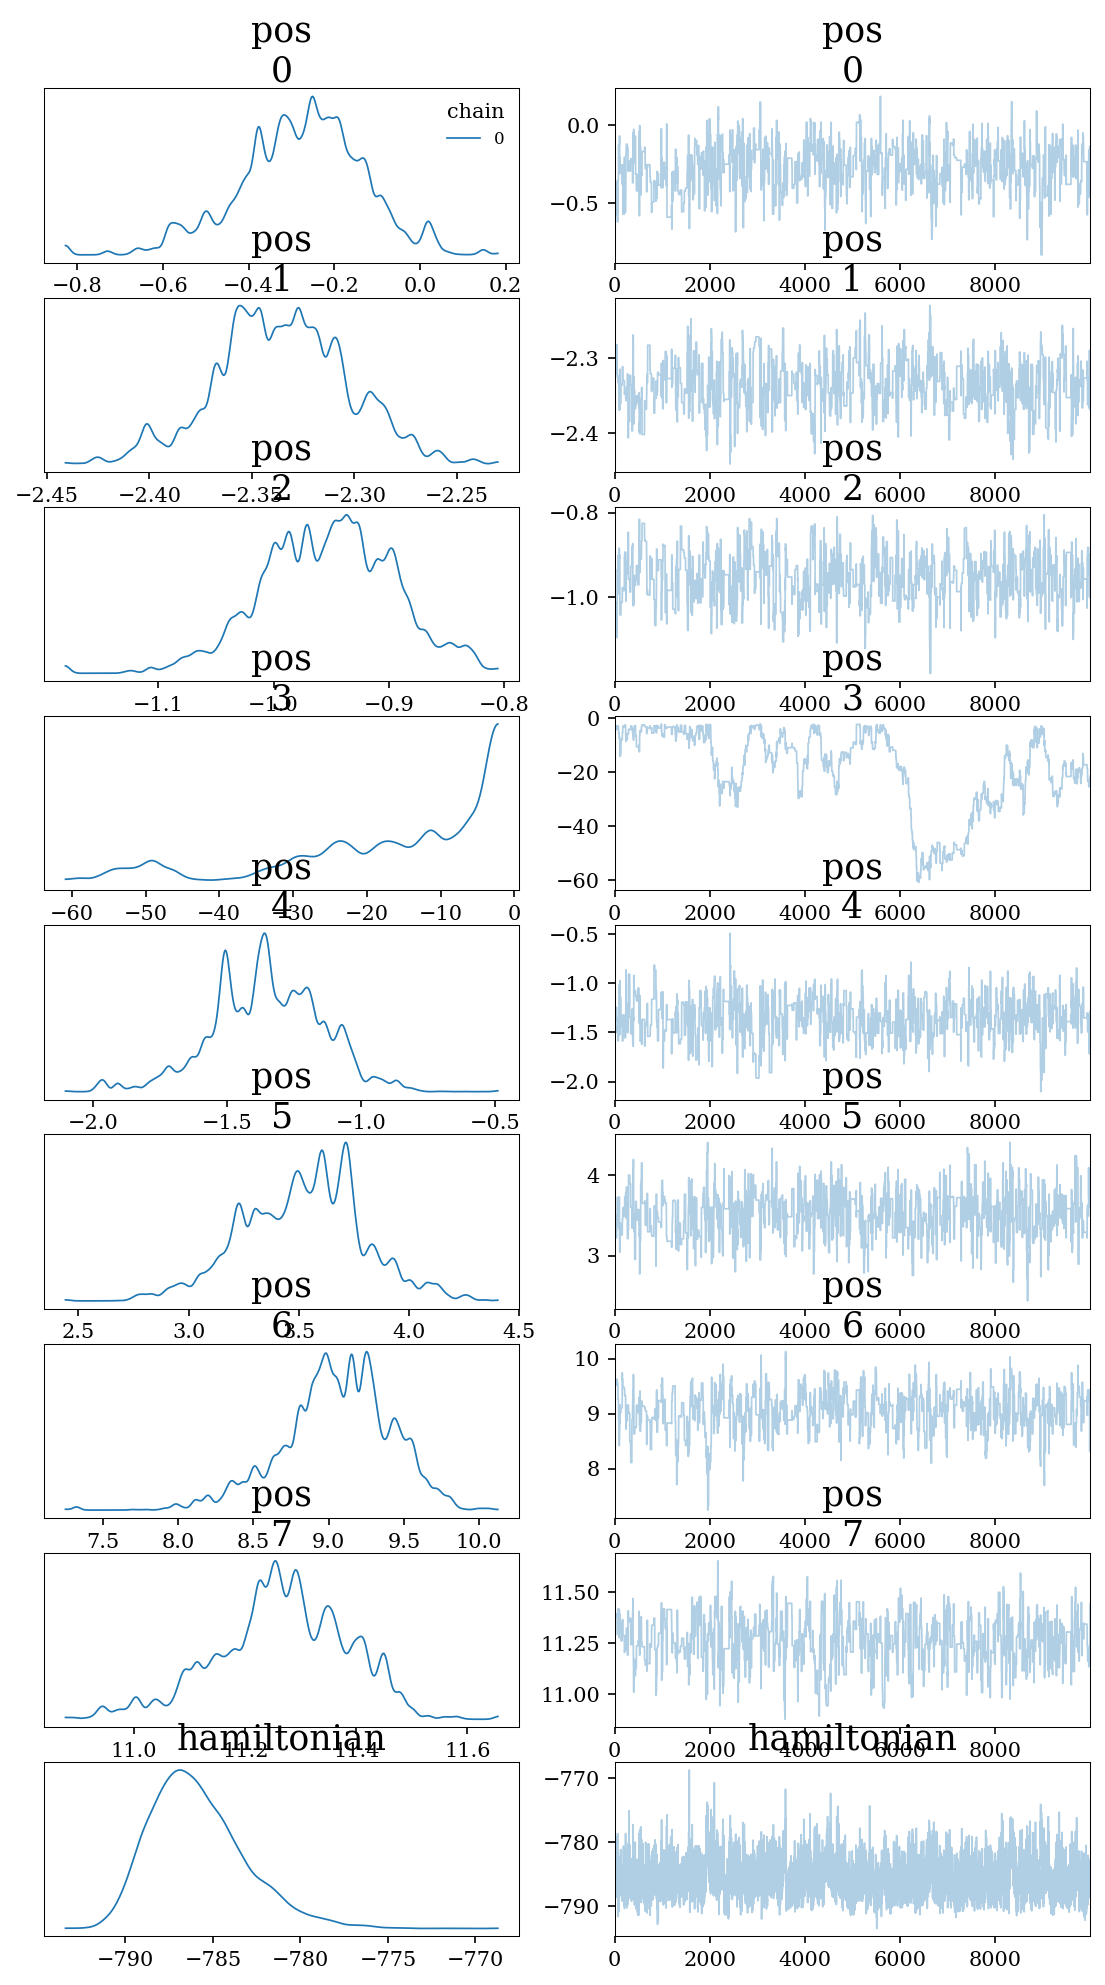

In [6]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (num_params)),
        legend=True,
        compact=False,
    )
plt.show()

# Transform the Chains

In [7]:
traces_transformed = {'pos': []}
traces_transformed['pos'].append(np.empty_like(traces['pos'][0]))
for i in range(0, 1): # theta
    traces_transformed['pos'][0][:, i] = mapRto01(traces['pos'][0][:, i])*(tmax-tmin) + tmin
for i in range(1, 4): # rho_eta, rho_delta
    traces_transformed['pos'][0][:, i] = ell2rho(mapRto0inf(traces['pos'][0][:, i]))
for i in range(4, num_params): # lambda_eta, lambda_delta, lambda_epsilon, lambda_epsilon_eta
    traces_transformed['pos'][0][:, i] = mapRto0inf(traces['pos'][0][:, i])

for i in range(num_params):
    print(np.mean(traces_transformed['pos'][0][:, i]), '±', np.std(traces_transformed['pos'][0][:, i]))



0.4274000045742716 ± 0.013987350942726191
2.213679840258793e-06 ± 2.046712135243701e-06
0.4313975795658708 ± 0.040870192990232826
1.2302001403100773e-07 ± 2.302949387731259e-06
0.2645283083523233 ± 0.05408206267786317
34.94617463333497 ± 9.569749054429199
9091.26086957866 ± 3105.4219594306946
78616.97507135315 ± 9150.421066213745


In [8]:
arviz.summary(traces_transformed)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pos[0],0.427,0.014,0.405,0.457,0.001,0.001,164.0,231.0,NaN
pos[1],0.000,0.000,0.000,0.000,0.000,0.000,232.0,315.0,NaN
pos[2],0.431,0.041,0.365,0.517,0.002,0.002,265.0,305.0,NaN
pos[3],0.000,0.000,0.000,0.000,0.000,0.000,14.0,11.0,NaN
pos[4],0.265,0.054,0.165,0.359,0.003,0.002,283.0,189.0,NaN
pos[5],34.946,9.570,18.100,51.850,0.465,0.329,417.0,559.0,NaN
pos[6],9091.261,3105.577,3292.418,14393.506,183.121,129.617,271.0,268.0,NaN
pos[7],78616.975,9150.879,62646.374,96835.047,544.640,385.517,282.0,274.0,NaN


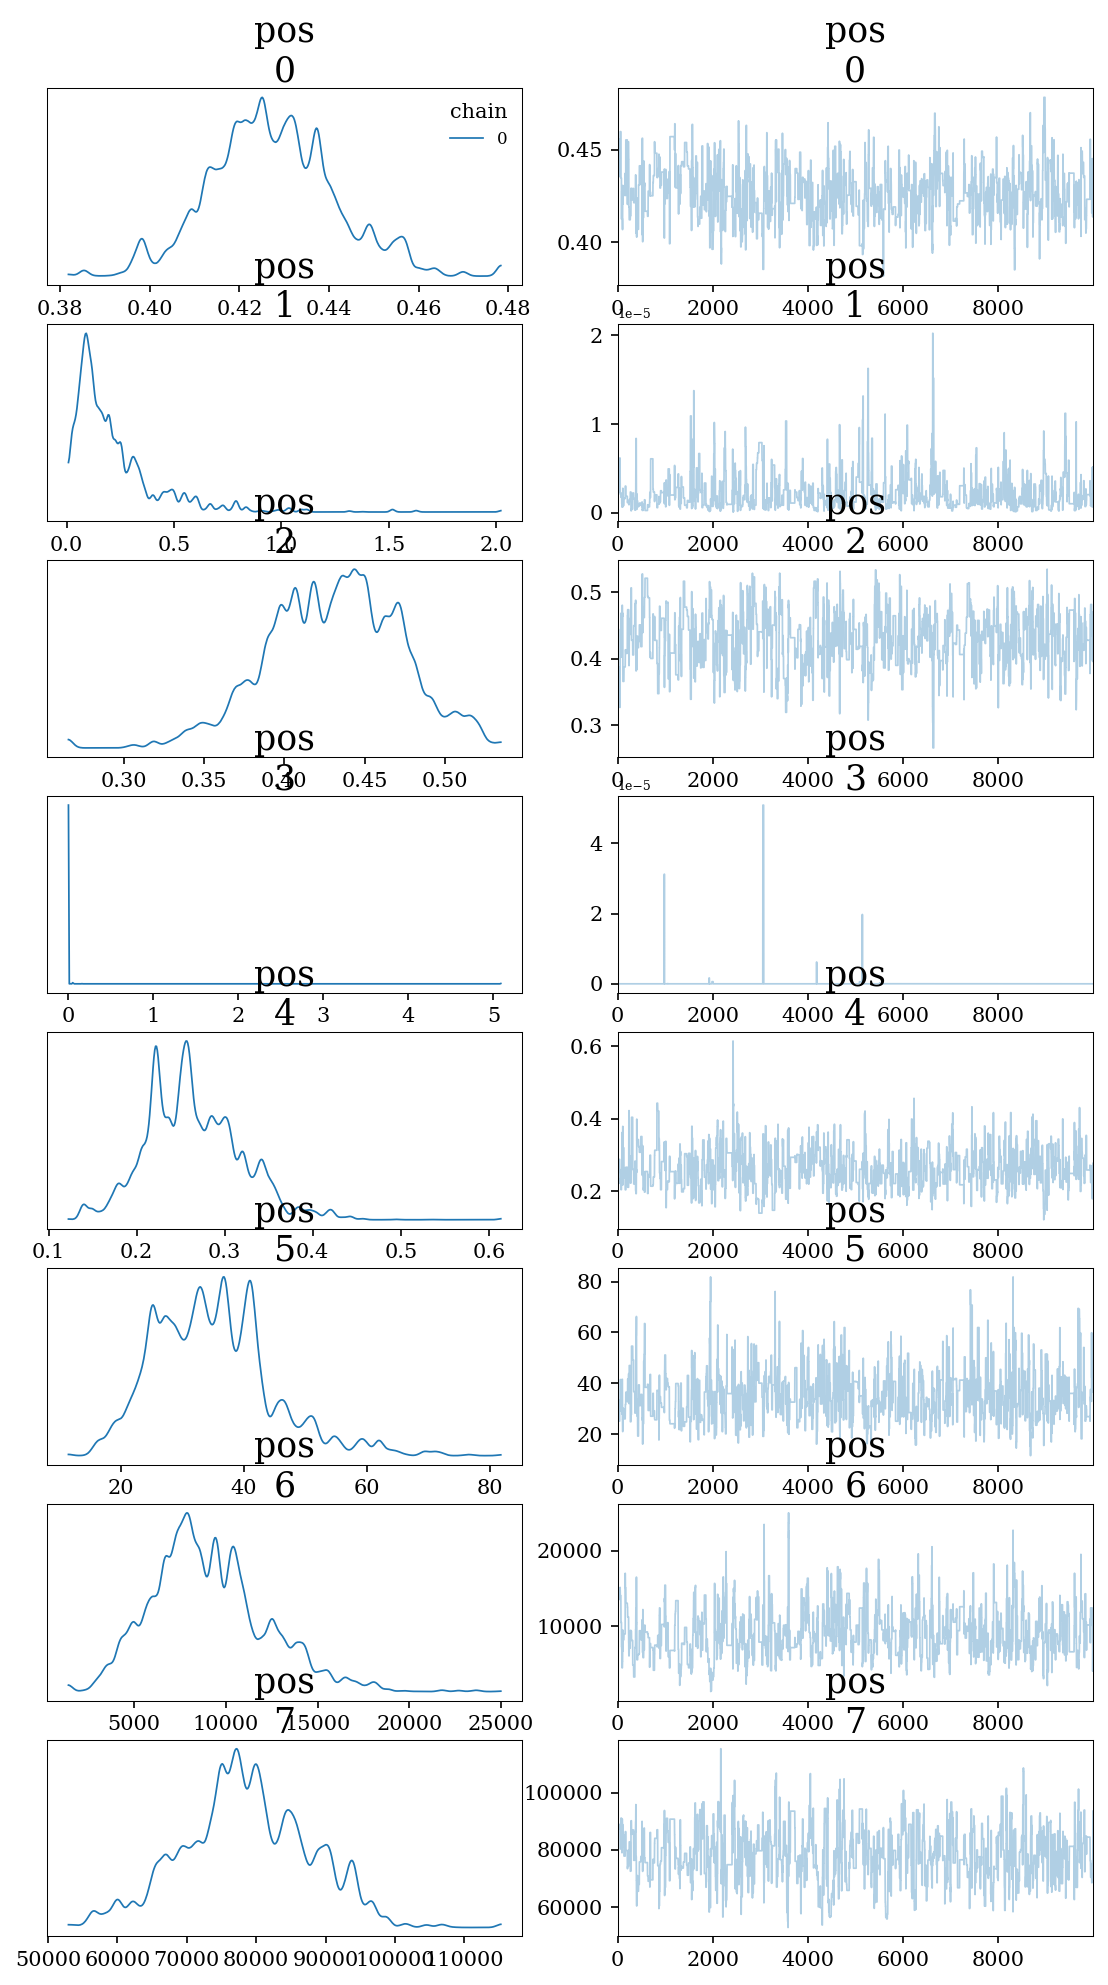

In [9]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (num_params)),
        legend=True,
        compact=False,
    )
plt.show()